# Noise in the wavelet domain

## 1. Imports

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
# from backgrounds import plotting
np.random.seed(1234)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


## 2. Generate data

In [2]:
def generate_noise(psd_func, n_data, fs):
    """
    Noise generator from arbitrary power spectral density.
    Uses a Gaussian random generation in the frequency domain.

    Parameters
    ----------
    psd_func: callable
        one-sided PSD function in A^2 / Hz, where A is the unit of the desired
        output time series. Can also return a p x p spectrum matrix
    n_data: int
        size of output time series
    fs: float
        sampling frequency in Hz


    Returns
    -------
    tseries: ndarray
        generated time series

    """

    # Number of points to generate in the frequency domain (circulant embedding)
    n_psd = 2 * n_data
    # Number of positive frequencies
    n_fft = int((n_psd-1)/2)
    # Frequency array
    f = np.fft.fftfreq(n_psd)*fs
    # Avoid zero frequency as it sometimes makes the PSD infinite
    f[0] = f[1]
    # Compute the PSD (or the spectrum matrix)
    psd_f = psd_func(np.abs(f))

    if psd_f.ndim == 1:
        psd_sqrt = np.sqrt(psd_f)
        # Real part of the Noise fft : it is a gaussian random variable
        noise_tf_real = np.sqrt(0.5) * psd_sqrt[0:n_fft + 1] * np.random.normal(
            loc=0.0, scale=1.0, size=n_fft + 1)
        # Imaginary part of the Noise fft :
        noise_tf_im = np.sqrt(0.5) * psd_sqrt[0:n_fft + 1] * np.random.normal(
            loc=0.0,  scale=1.0, size=n_fft + 1)
        # The Fourier transform must be real in f = 0
        noise_tf_im[0] = 0.
        noise_tf_real[0] = noise_tf_real[0]*np.sqrt(2.)
        # Create the NoiseTF complex numbers for positive frequencies
        noise_tf = noise_tf_real + 1j*noise_tf_im

    # To get a real valued signal we must have NoiseTF(-f) = NoiseTF*
    if (n_psd % 2 == 0) & (psd_f.ndim == 1):
        # The TF at Nyquist frequency must be real in the case of an even
        # number of data
        noise_sym0 = np.array([psd_sqrt[n_fft + 1] * np.random.normal(0, 1)])
        # Add the symmetric part corresponding to negative frequencies
        noise_tf = np.hstack((noise_tf, noise_sym0,
                              np.conj(noise_tf[1:n_fft+1])[::-1]))
    elif (n_psd % 2 != 0) & (psd_f.ndim == 1):
        noise_tf = np.hstack((noise_tf, np.conj(noise_tf[1:n_fft+1])[::-1]))

    tseries = np.fft.ifft(np.sqrt(n_psd*fs/2.) * noise_tf, axis=0)

    return tseries[0:n_data].real


def periodogram(x, fs, wd_func=np.blackman):
    """Compute the periodogram of a time series using the
    Blackman window

    Parameters
    ----------
    x : ndarray
        intput time series
    fs : float
        sampling frequency
    wd_func : callable
        tapering window function in the time domain

    Returns
    -------
    ndarray
        periodogram at Fourier frequencies
    """
    wd = wd_func(x.shape[0])
    k2 = np.sum(wd**2)
    if x.ndim == 1:
        per = np.abs(np.fft.fft(x * wd))**2 * 2 / (k2*fs)
    elif x.ndim == 2:
        per = np.abs(np.fft.fft(x * wd[:, np.newaxis], axis=0))**2 * 2 / (k2*fs)
        
    return per

In [3]:
def PowerSpectralDensity(f):
    """
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf
    Removed galactic confusion noise. Non stationary effect.
    """

    L = 2.5 * 10**9  # Length of LISA arm
    f0 = 19.09 * 10**-3

    Poms = ((1.5 * 10**-11) ** 2) * (
        1 + ((2 * 10**-3) / f) ** 4
    )  # Optical Metrology Sensor
    Pacc = (
        (3 * 10**-15) ** 2
        * (1 + (4 * 10**-3 / (10 * f)) ** 2)
        * (1 + (f / (8 * 10**-3)) ** 4)
    )  # Acceleration Noise

    PSD = (
        (10 / (3 * L**2))
        * (Poms + (4 * Pacc) / ((2 * np.pi * f)) ** 4)
        * (1 + 0.6 * (f / f0) ** 2)
    )  # PSD

    return PSD

def psd_func(f, fmin=1e-3):
    
    # if isinstance(f, np.ndarray):
    #     out = np.zeros_like(f)
    #     out[f>=fmin] = PowerSpectralDensity(f[f>fmin])
    #     out[f<fmin] = PowerSpectralDensity(fmin)
    # elif isinstance(f, float):
    #     if f < fmin:
    #         out = PowerSpectralDensity(fmin)
    #     else:
    #         out = PowerSpectralDensity(f)

    out = PowerSpectralDensity(f) * f**4

    return out

In [4]:
tmax = 120*60*60    # Final time
fs = 0.1           # Sampling rate
delta_t = 1/fs      # Sampling interval -- largely oversampling here. 
n_data = 2**int(np.log(tmax/delta_t)/np.log(2))
t = np.arange(0, n_data) * delta_t
# Generate stationary noise in the time domain
data_noise = generate_noise(psd_func, n_data, fs)

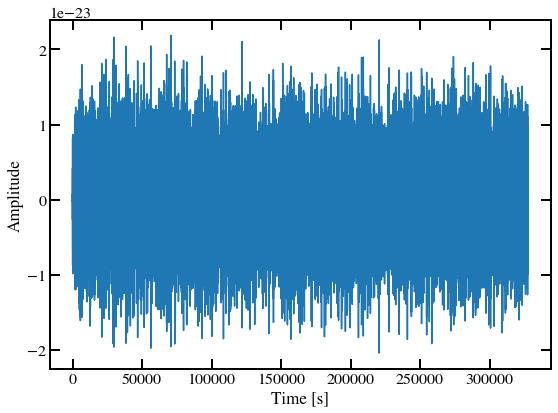

In [9]:
# plotting.plotconfig(lbsize=17, lgsize=14, autolayout=True, figsize=[8, 6],
#                     ticklabelsize=16, fsize=15, fontfamily='STIXGeneral',
#                     tdir='in', major=10, minor=7, lwidth=2)

plt.figure(0)
plt.plot(t, data_noise, rasterized=True)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
# plt.savefig("../../../figures/colored_noise_time_series.pdf")
plt.show()

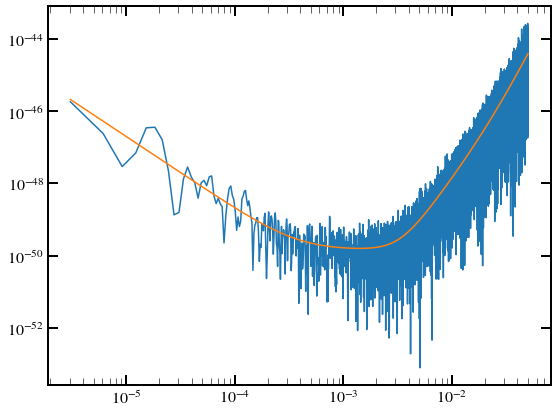

In [10]:
f = np.fft.fftfreq(n_data) * fs
per = periodogram(data_noise, fs)[f>0]
s_n = psd_func(f[f>0])
plt.figure(0)
plt.loglog(f[f>0], per)
plt.loglog(f[f>0], s_n)
plt.show()

In [11]:
# Apply a modulation to this noise
a_true = 1.0 # 5e-21
f_true = 1e-5
alpha = 0.5
data_noise_mod = data_noise * (1.0 + alpha * np.cos(2 * np.pi * f_true * t))

In [12]:
amplitude = 1.0 + alpha * np.cos(2 * np.pi * f_true * t)

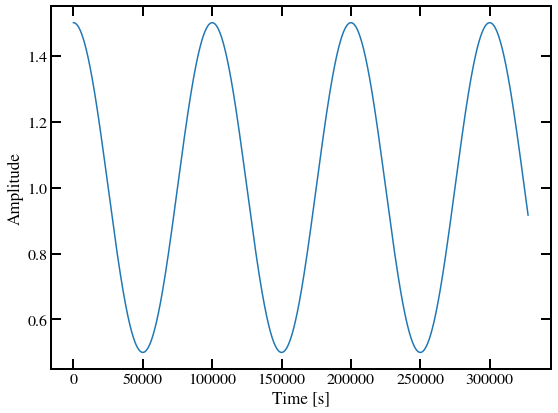

In [13]:
plt.figure(0)
plt.plot(t, amplitude, rasterized=True)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.savefig("../../../figures/varying_amplitude_time_series.pdf")
plt.show()

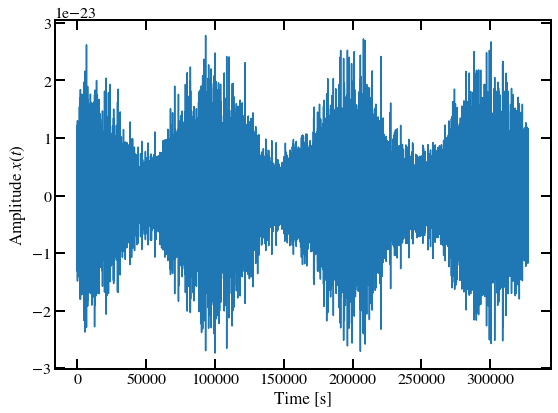

In [29]:
plt.figure(0)
plt.plot(t, data_noise_mod)
plt.xlabel("Time [s]")
plt.ylabel(r"Amplitude $x(t)$")
plt.savefig("../../../figures/non_stationary_time_series.pdf")
plt.show()

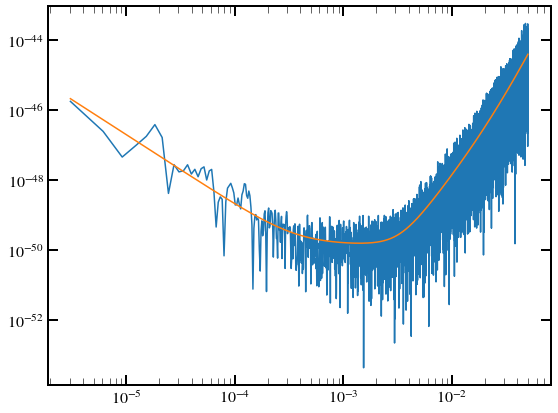

In [15]:
f = np.fft.fftfreq(n_data) * fs
per_mode = periodogram(data_noise_mod, fs)[f>0]
plt.figure(0)
plt.loglog(f[f>0], per_mode)
plt.loglog(f[f>0], s_n)
plt.show()

## 3. Build frequency-domain analytical spectrum

In [16]:
from pywavelet.transforms import from_time_to_wavelet
from pywavelet.transforms import common
from matplotlib.colors import LogNorm

def plot_wavelet_domain_signal(wavelet_data, time_grid, freq_grid, freq_range,
                               yscale="linear", zscale="linear"):
    fig = plt.figure()
    z = np.abs(np.rot90(wavelet_data))
    if zscale == "log":
        norm = LogNorm(vmin=np.min(z), vmax=np.max(z))
    elif zscale == "linear":
        norm = None
    plt.imshow(
        z,
        aspect="auto",
        extent=[time_grid[0], time_grid[-1], freq_grid[0], freq_grid[-1]],
        norm=norm
    )
    cbar = plt.colorbar()
    cbar.set_label("Wavelet Amplitude")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.yscale(yscale)
    plt.ylim(*freq_range)
    plt.tight_layout()
    return fig


# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
# # ax.matshow(np.abs(yw))
# fmin = fs/(2*nf)
# fmax = fs/2
# vmin = 1e-4
# extent = np.min(t), np.max(t), fmin, fmax
# ax.imshow(np.abs(yw), norm=LogNorm(vmin=vmin, vmax=np.max(np.abs(yw))),
#           interpolation='bilinear',
#           extent=extent, aspect='auto')
# ax.set_yscale("log")
# # ax.set_ylim([1e-4, fs/2])
# # ax.set_yscale("log")
# # ax.set_xlim([0, 100])
# # ax.set_ylim([1, 100])
# # plt.tight_layout()
# plt.show()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject


In [17]:
# Size of the data
ND = data_noise_mod.size
tobs = delta_t * ND
# We know that the data varies slowly with f_true
# The durations where the process is approximately stationary should be 
# much smaller than t_true = 1/f_true
# If we pick dt = t_true / 10
print("The duration over which the process is approximately stationary is " + str(1/f_true/10))
print(tobs)

q = int(np.log(n_data)/np.log(2))
qf = int(q/2)+1
Nf = 2**(qf)
Nt = 2**(q - qf)
print(ND)
print(Nf*Nt)
mult = 32
K = mult*2*Nf

# Here are
df = Nt / (2 * tobs)
dt = tobs / Nt

print("The chosen wavelet time resolution is " + str(dt))
print("The chosen wavelet frequency resolution is " + str(df))

The duration over which the process is approximately stationary is 9999.999999999998
327680.0
32768
32768
The chosen wavelet time resolution is 2560.0
The chosen wavelet frequency resolution is 0.0001953125


In [18]:
data_noise_mod_w = from_time_to_wavelet(data_noise_mod, Nt=Nt, Nf=Nf, nx=4.0, mult=mult)

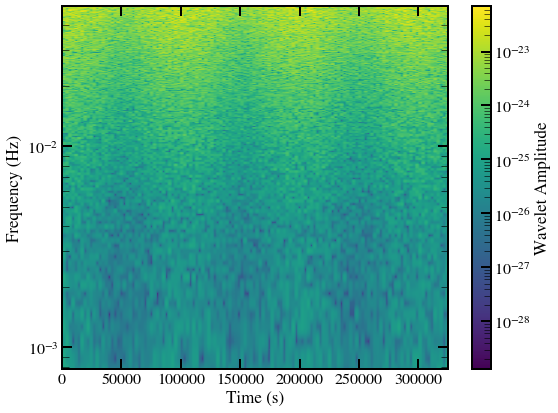

In [30]:
# time and frequency grids
fm = np.arange(0, Nf) * df
fm[0] = fm[1]
tn = np.arange(0, Nt) * dt
# t_grid = np.arange(0, ND) * delta_t
# f_grid = np.arange(0, ND // 2 + 1) * 1 / (tobs)
freq_range = (4*df, fm[-1])
fig = plot_wavelet_domain_signal(np.abs(data_noise_mod_w), tn, fm, freq_range,
                                 yscale="log", zscale="log")
# plt.savefig("../../../figures/non_stationary_wavelet.pdf")

Now assume that the evolutionary spectrum is given by

$$
S(t, f) = S_{n}(f) \left(1 + \alpha \cos(2 \pi f_0 t)\right)^2
$$


In [20]:
def amplitude_func(t):
    return (1.0 + alpha * np.cos(2 * np.pi * f_true * t))

def spectrum_model(t, f):    
    return psd_func(f) * amplitude_func(t)**2

In [21]:
stf = np.dot(np.asarray([amplitude_func(tn)**2]).T, np.asarray([psd_func(fm)]))

In [22]:
print(data_noise_mod_w.shape)
print(stf.shape)

(128, 256)
(128, 256)


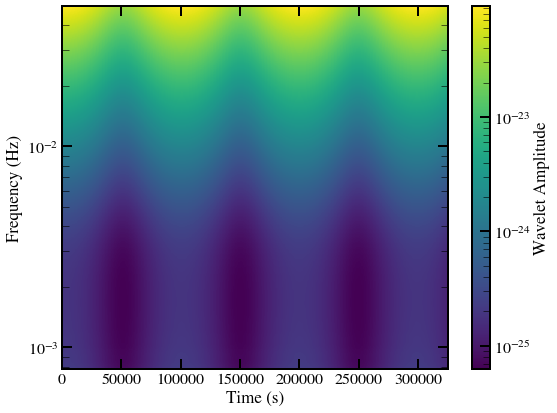

In [23]:
fig = plot_wavelet_domain_signal(np.sqrt(stf), tn, fm, freq_range,
                                 yscale="log", zscale="log")

In [24]:
# Try to weight the data
ratios = np.abs(data_noise_mod_w)**2 / stf

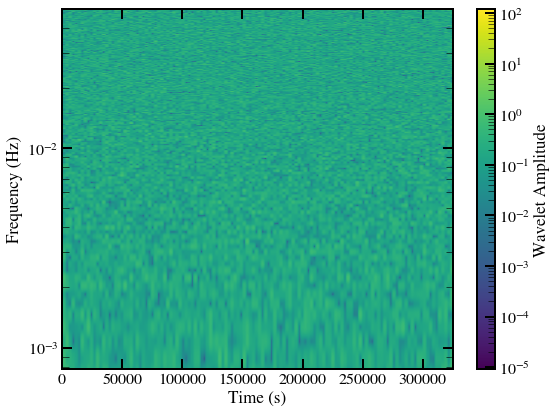

In [25]:
fig = plot_wavelet_domain_signal(np.sqrt(ratios), tn, fm, freq_range,
                                 yscale="log", zscale="log")

In [26]:
np.mean(ratios * Nt / np.pi)
print(ratios.shape)
print(fm.shape)

(128, 256)
(256,)


In [27]:
iok = np.where(fm >= 4*df)
amp_ratios = data_noise_mod_w[:, iok] / np.sqrt(stf[:, iok] * fs / 2)
print(np.var(amp_ratios))

1.0114313283827758


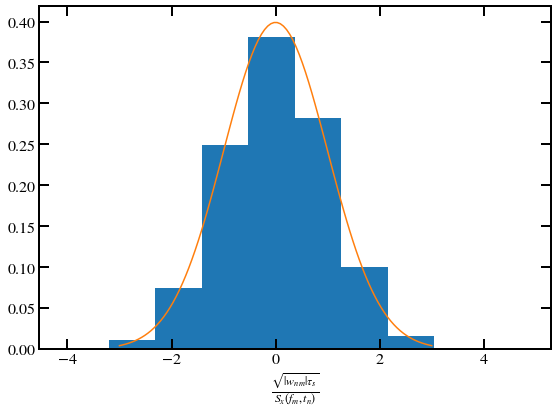

In [32]:
x = np.linspace(-3, 3, 100)
plt.figure(0)
plt.hist(amp_ratios.flatten(), density=True) #, range=[0, 0.5])
plt.plot(x, stats.norm.pdf(x))
plt.xlabel(r"$\frac{\sqrt{|w_{nm}| \tau_s}}{S_{x}(f_m, t_n)}$")
# plt.savefig("../../../figures/wavelet_statistics.pdf")
plt.show()